In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz

In [5]:
file_path = "./Datasets/loan_approval_dataset.csv"
data = pd.read_csv(file_path)
print(data.sample(10))
print(data.describe())

      loan_id   no_of_dependents      education  self_employed   income_annum  \
748       749                  4       Graduate             No        2700000   
2161     2162                  0   Not Graduate             No        6400000   
2422     2423                  2       Graduate             No        4600000   
4182     4183                  1   Not Graduate             No         400000   
195       196                  3       Graduate             No        9200000   
1913     1914                  5       Graduate             No        5800000   
4268     4269                  1       Graduate             No        9200000   
424       425                  4       Graduate            Yes        6100000   
712       713                  0       Graduate            Yes        6100000   
3517     3518                  0   Not Graduate             No        6900000   

       loan_amount   loan_term   cibil_score   residential_assets_value  \
748       10200000           4   

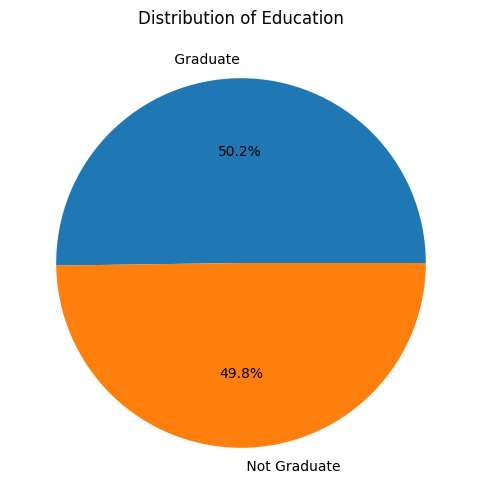

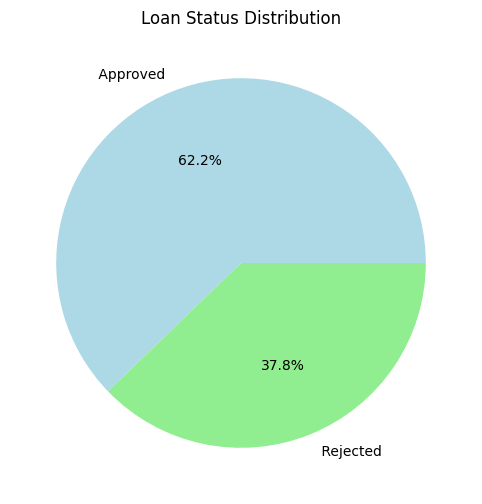

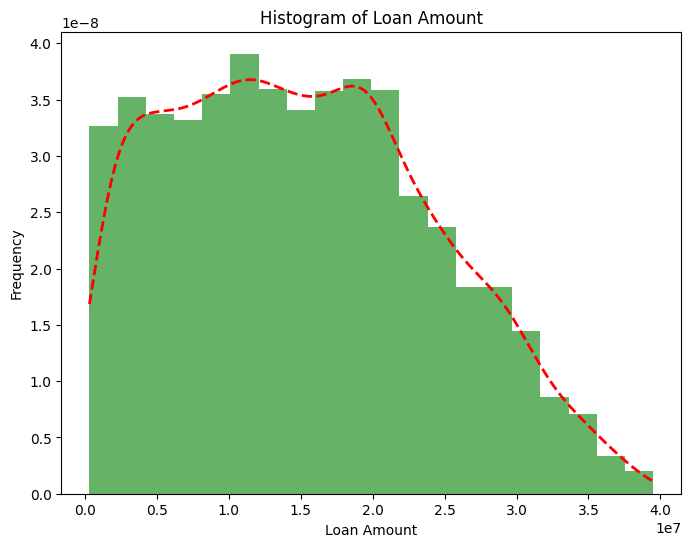

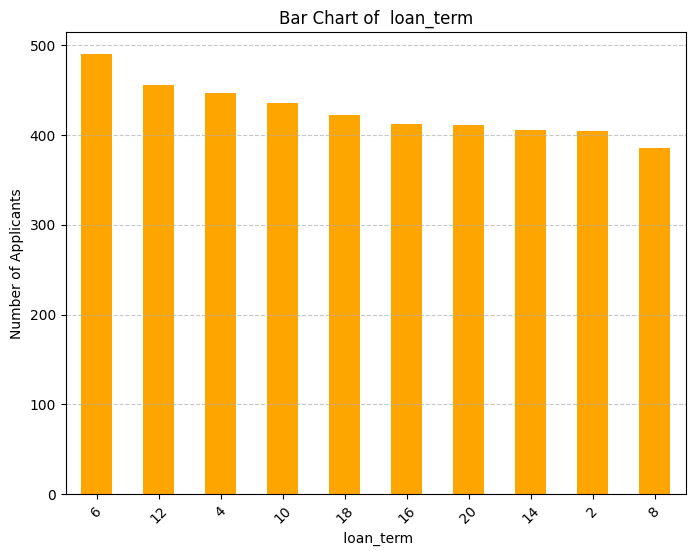

In [7]:
# Data Visualization


data.columns = data.columns.str.strip()

# Pie Chart
plt.figure(figsize=(8, 6))
data['education'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Education')
plt.ylabel('')
plt.show()
print('\n')

# Pie Chart
plt.figure(figsize=(8, 6))
data['loan_status'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Loan Status Distribution')
plt.ylabel('')
plt.show()
print('\n')

# Histogram
plt.figure(figsize=(8, 6))
plt.hist(data['loan_amount'], bins=20, density=True, alpha=0.6, color='g')
kde = stats.gaussian_kde(data['loan_amount'])
x = np.linspace(min(data['loan_amount']), max(data['loan_amount']), 1000)
y = kde(x)
plt.plot(x, y, 'r--', linewidth=2)
plt.title('Histogram of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')
plt.show()
print('\n')

# Bar Chart
education_counts = data['loan_term'].value_counts()
plt.figure(figsize=(8, 6))
education_counts.plot(kind='bar', color='orange')
plt.title('Bar Chart of  loan_term')
plt.xlabel(' loan_term')
plt.ylabel('Number of Applicants')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [8]:


# Check for missing values
data.dropna(inplace=True)
data.columns = data.columns.str.strip()

# Drop some of columns
data.drop('loan_id', axis=1, inplace=True)
data.drop('no_of_dependents', axis=1, inplace=True)

# Encode categorical features using one-hot encoding
data = pd.get_dummies(data, columns=['education', 'self_employed'], drop_first=True)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['income_annum', 'loan_amount', 'loan_term', 'cibil_score',
                  'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Handle missing values (example: fill with mean for numerical columns)
for col in data.columns:
    if data[col].dtype == 'object':
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        data[col].fillna(data[col].mean(), inplace=True)

# Outlier detection
z_scores = stats.zscore(data.select_dtypes(include=[np.number]))
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data = data[filtered_entries]

# create a new feature 'total_assets_value' which sums up all asset values
data['total_assets_value'] = data['residential_assets_value'] + data['commercial_assets_value'] + data['luxury_assets_value'] + data['bank_asset_value']

# Drop the individual asset value columns as they are now redundant
data.drop(['residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value'], axis=1, inplace=True)

X = data.drop('loan_status', axis=1)
y = data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the classifier to the training data
dt_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = dt_classifier.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=' Approved')
recall = recall_score(y_test, y_pred, pos_label=' Approved')
f1 = f1_score(y_test, y_pred, pos_label=' Approved')

# Display evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9846698113207547
Precision: 0.98828125
Recall: 0.98635477582846
F1 Score: 0.9873170731707317


/tmp/ipykernel_23112/1965612957.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)
/tmp/ipykernel_23112/1965612957.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [9]:
# Define the grid of hyperparameters
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the decision tree classifier
dt_classifier = DecisionTreeClassifier(random_state=13)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Initialize the decision tree classifier with best hyperparameters
best_dt_classifier = DecisionTreeClassifier(random_state=42, **best_params)

# Fit the classifier to the training data with best hyperparameters
best_dt_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred_best = best_dt_classifier.predict(X_test)

# Evaluate model performance with best hyperparameters
accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, pos_label=' Approved')
recall_best = recall_score(y_test, y_pred_best, pos_label=' Approved')
f1_best = f1_score(y_test, y_pred_best, pos_label=' Approved')

# Display evaluation metrics for the model with best hyperparameters
print("Model with Best Hyperparameters:")
print("Accuracy:", accuracy_best)
print("Precision:", precision_best)
print("Recall:", recall_best)
print("F1 Score:", f1_best)

Best Hyperparameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Model with Best Hyperparameters:
Accuracy: 0.9823113207547169
Precision: 0.9825581395348837
Recall: 0.9883040935672515
F1 Score: 0.9854227405247813


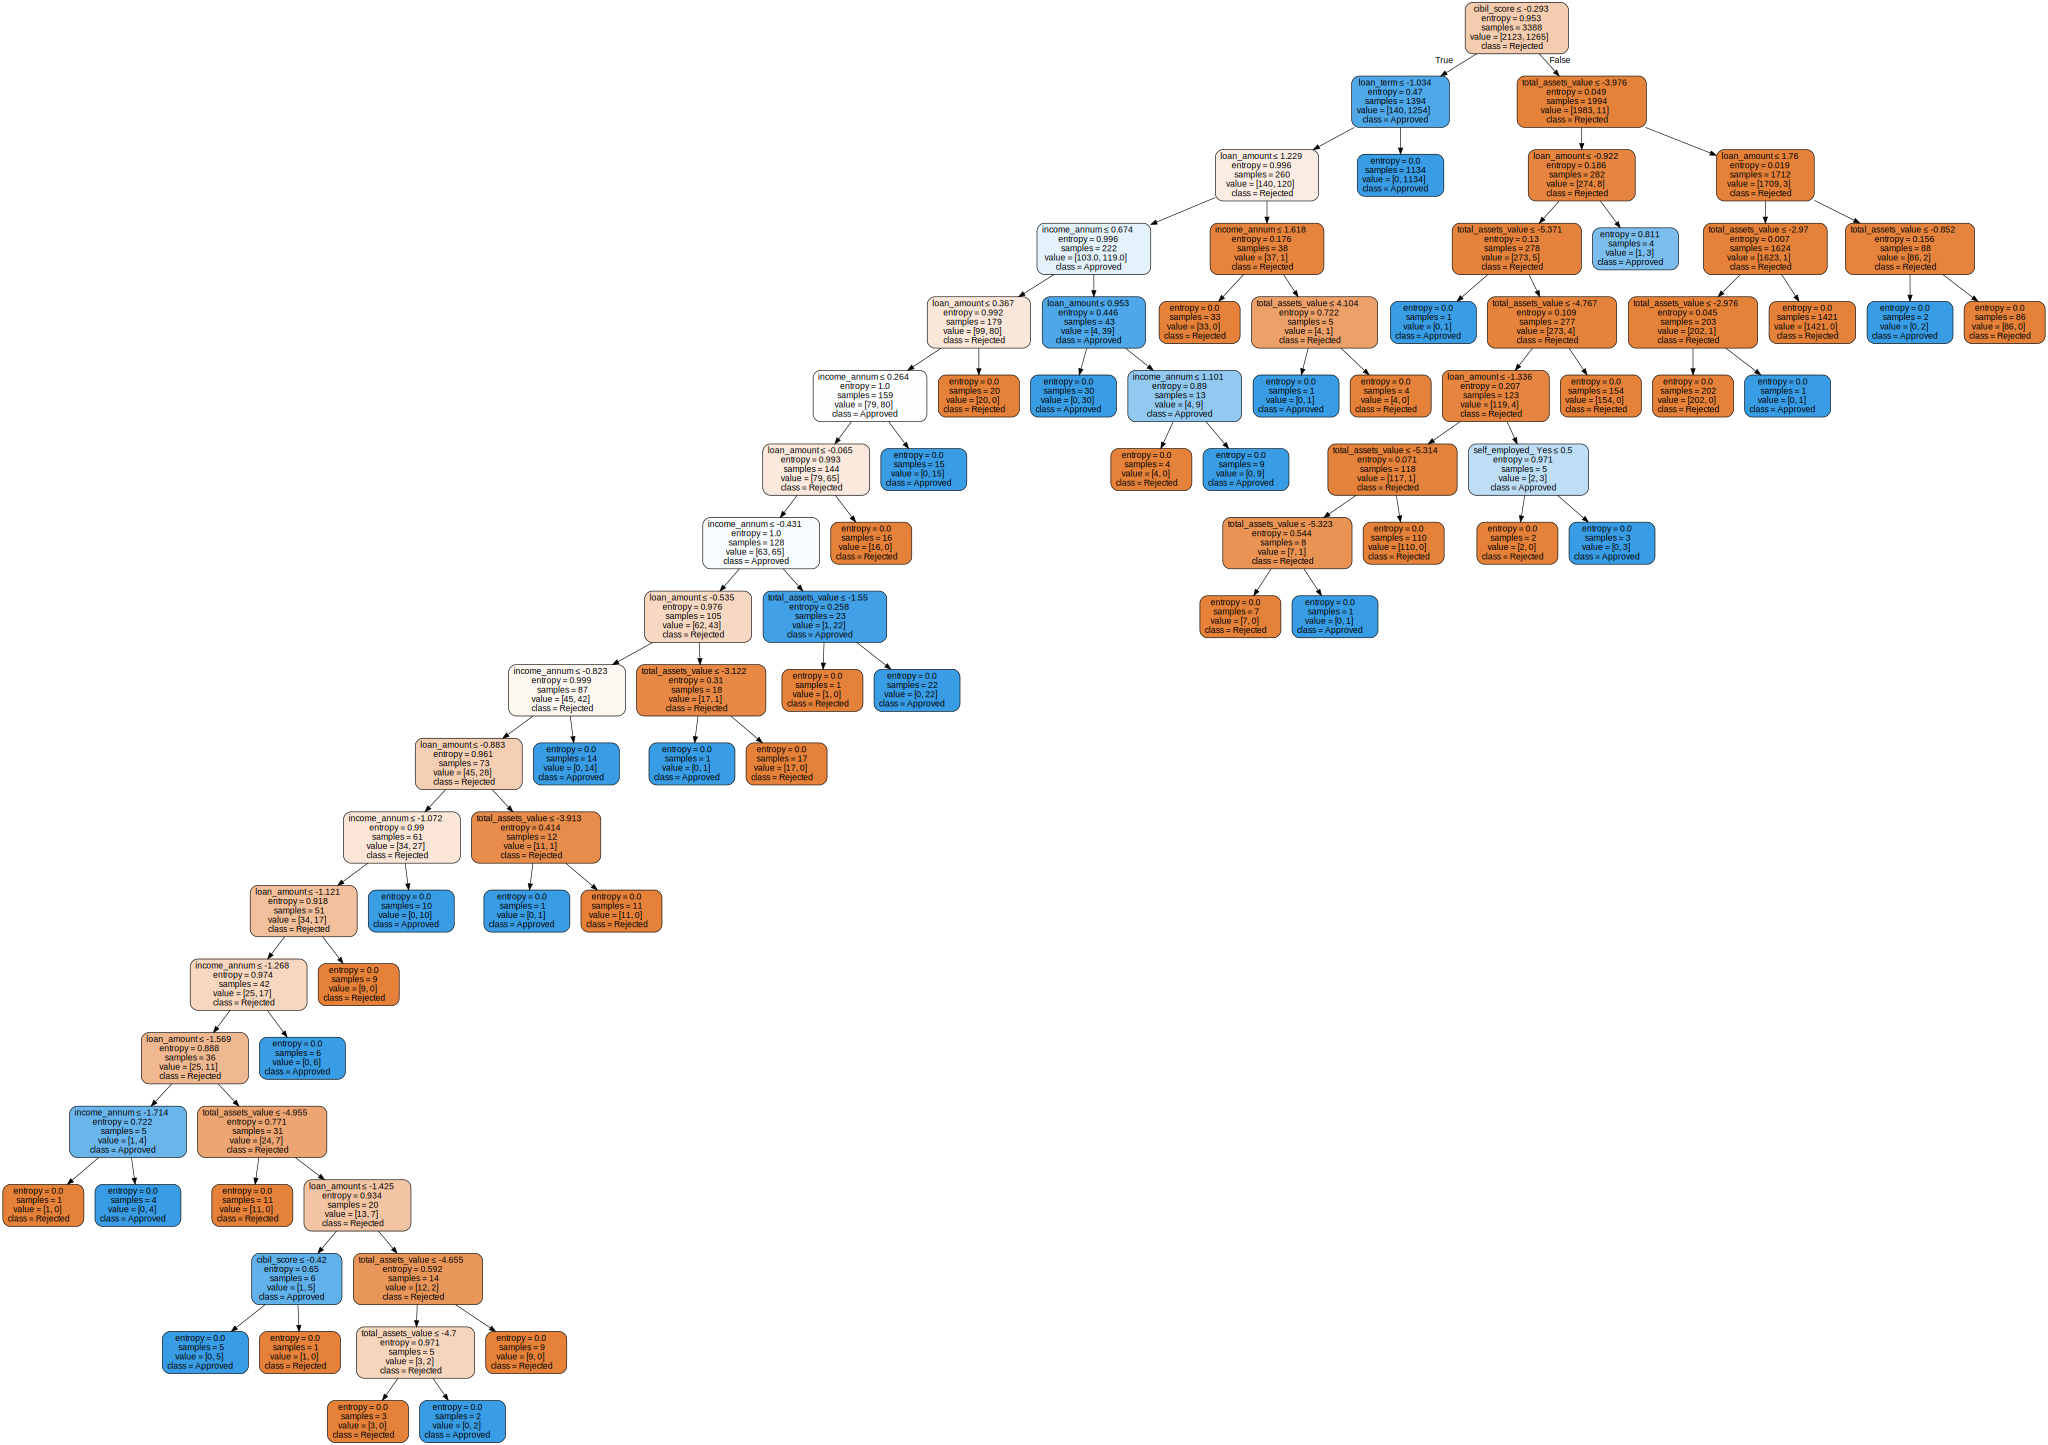

In [10]:
# Export the decision tree as a DOT file
dot_data = export_graphviz(best_dt_classifier, out_file=None,
                           feature_names=X.columns,
                           class_names=['Rejected', 'Approved'],
                           filled=True, rounded=True, special_characters=True)

# Visualize the decision tree using graphviz
graph = graphviz.Source(dot_data)
graph.format = 'png'
graph.render('decision_tree', view=True)

# display graph
graph

In [13]:
# Save the unpruned decision tree graph as a PNG file
graph.render('./Pictures/tree.png', format='png', cleanup=True)


'Pictures/tree.png.png'

In [14]:
# Initialize the decision tree classifier with pruning parameters
pruned_dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=5, min_samples_leaf=2)

# Fit the pruned decision tree classifier to the training data
pruned_dt_classifier.fit(X_train, y_train)

# Predict on the test data using the pruned decision tree
y_pred_pruned = pruned_dt_classifier.predict(X_test)

# Evaluate model performance with pruning
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
precision_pruned = precision_score(y_test, y_pred_pruned, pos_label=' Approved')
recall_pruned = recall_score(y_test, y_pred_pruned, pos_label=' Approved')
f1_pruned = f1_score(y_test, y_pred_pruned, pos_label=' Approved')

# Display evaluation metrics for the pruned model
print("Pruned Decision Tree Model Performance:")
print("Accuracy:", accuracy_pruned)
print("Precision:", precision_pruned)
print("Recall:", recall_pruned)
print("F1 Score:", f1_pruned)

Pruned Decision Tree Model Performance:
Accuracy: 0.9658018867924528
Precision: 0.9801587301587301
Recall: 0.9629629629629629
F1 Score: 0.9714847590953786


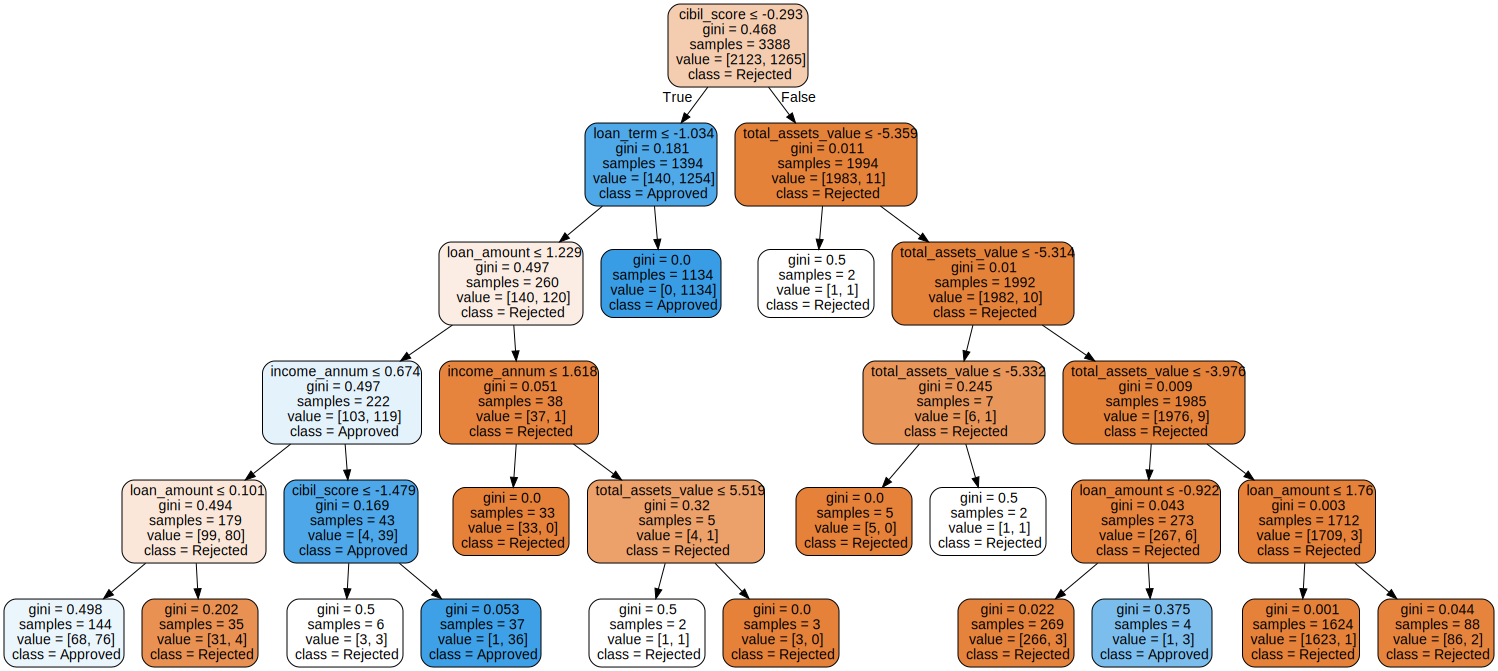

In [33]:
# Export the pruned decision tree as a DOT file
dot_data_pruned = export_graphviz(pruned_dt_classifier, out_file=None,
                                   feature_names=X.columns,
                                   class_names=['Rejected', 'Approved'],
                                   filled=True, rounded=True, special_characters=True)

# Visualize the pruned decision tree using graphviz
graph_pruned = graphviz.Source(dot_data_pruned)
graph_pruned.format = 'png'
graph_pruned.render('pruned_decision_tree', view=True)

# display graph
graph_pruned

In [38]:
# Save the pruned decision tree graph as a PNG file
graph_pruned.render('/content/drive/MyDrive/pruned_decision_tree', format='png', cleanup=True)

# Download the saved graph file
files.download('/content/drive/MyDrive/pruned_decision_tree.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>